In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [3]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from loading import load_session_data
from scipy import stats
from scipy import signal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.cluster import DBSCAN
from population import unit_response_matrix, activity_at_phase

from umap import UMAP  # conda install -c conda-forge umap-learn
from sklearn.manifold import TSNE

2024-07-24 12:38:27.865658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 12:38:31.043977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-24 12:38:31.043992: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-24 12:38:31.129718: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 12:38:32.380212: W tensorflow/stream_executor/platform/de

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:10]
try:
    selected.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17']

In [6]:
umap_dists        = [0.1, 0.3]
perplexities      = [70, 100]
umap_fits         = {}
tsne_fits         = {}
idxs_srm_succ_all = {}
idxs_srm_fail_all = {}

In [8]:
source    = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
session   = '009266_hippoSIT_2023-04-17_17-04-17'
animal    = session.split('_')[0]
s_path    = os.path.join(source, animal, session)
meta_file = os.path.join(source, animal, session, 'meta.h5')

# read dataset
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])

# indices of BGR / TGT
idxs_bgr = np.where(events[:, 1] == 1)[0]
idxs_tgt = np.where(events[:, 1] == 2)[0]

# indices of success stays in the target
idxs_srm_succ = []
for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
    idxs_srm_succ += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_srm_succ = np.array(idxs_srm_succ)

In [20]:
for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    _file = os.path.join(source, animal, session, 'analysis', 'MoSeq_class_500.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    
    idxs_bgr = np.where(events[:, 1] == 1)[0]
    idxs_tgt = np.where(events[:, 1] == 2)[0]
    
    
    idxs_srm_succ = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_srm_succ += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_srm_succ_all[session] = np.array(idxs_srm_succ)
    
    idxs_srm_fail = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 0]:
        idxs_srm_fail += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_srm_fail_all[session] = idxs_srm_fail
    
    resp_mx = np.zeros([len(events), 4])
    for j, phase in enumerate([1, 2, 3, 4]):
        resp_mx[:, j] = activity_at_phase(s_path, phase, do_pca=True)

    tsne_fits[session] = {}
    for perp in perplexities:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=0)
        tsne_fit = tsne.fit_transform(resp_mx)
        tsne_fits[session][perp] = tsne_fit
        
    umap_fits[session] = {}
    for dist in umap_dists:
        umap_2d = UMAP(n_components=2, n_neighbors=30, min_dist=dist, random_state=0)
        umap_fit = umap_2d.fit_transform(resp_mx)
        umap_fits[session][dist] = umap_fit
        
    print(session + ' done')

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobol

009266_hippoSIT_2023-04-17_17-04-17 done


/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobol

009266_hippoSIT_2023-04-18_10-10-37 done


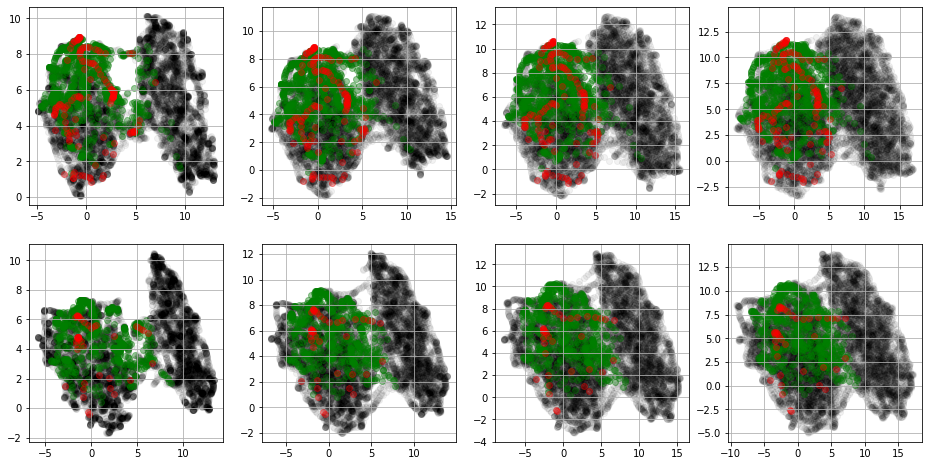

In [23]:
rows = len(selected)
cols = 4
size = 4
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

for i, session in enumerate(selected):
    for j, dist in enumerate(umap_dists):
        fit = umap_fits[session][dist]
        idxs_succ = idxs_srm_succ_all[session]
        idxs_fail = idxs_srm_fail_all[session]
        
        ax = axes[i][j]
        ax.scatter(fit[:, 0], fit[:, 1], alpha=0.05, color='black')
        ax.scatter(fit[idxs_succ][:, 0], fit[idxs_succ][:, 1], alpha=0.35, color='green')
        ax.scatter(fit[idxs_fail][:, 0], fit[idxs_fail][:, 1], alpha=0.35, color='red')
        ax.grid()

## Just do W1 and W4 scatter and plot success / fail on it

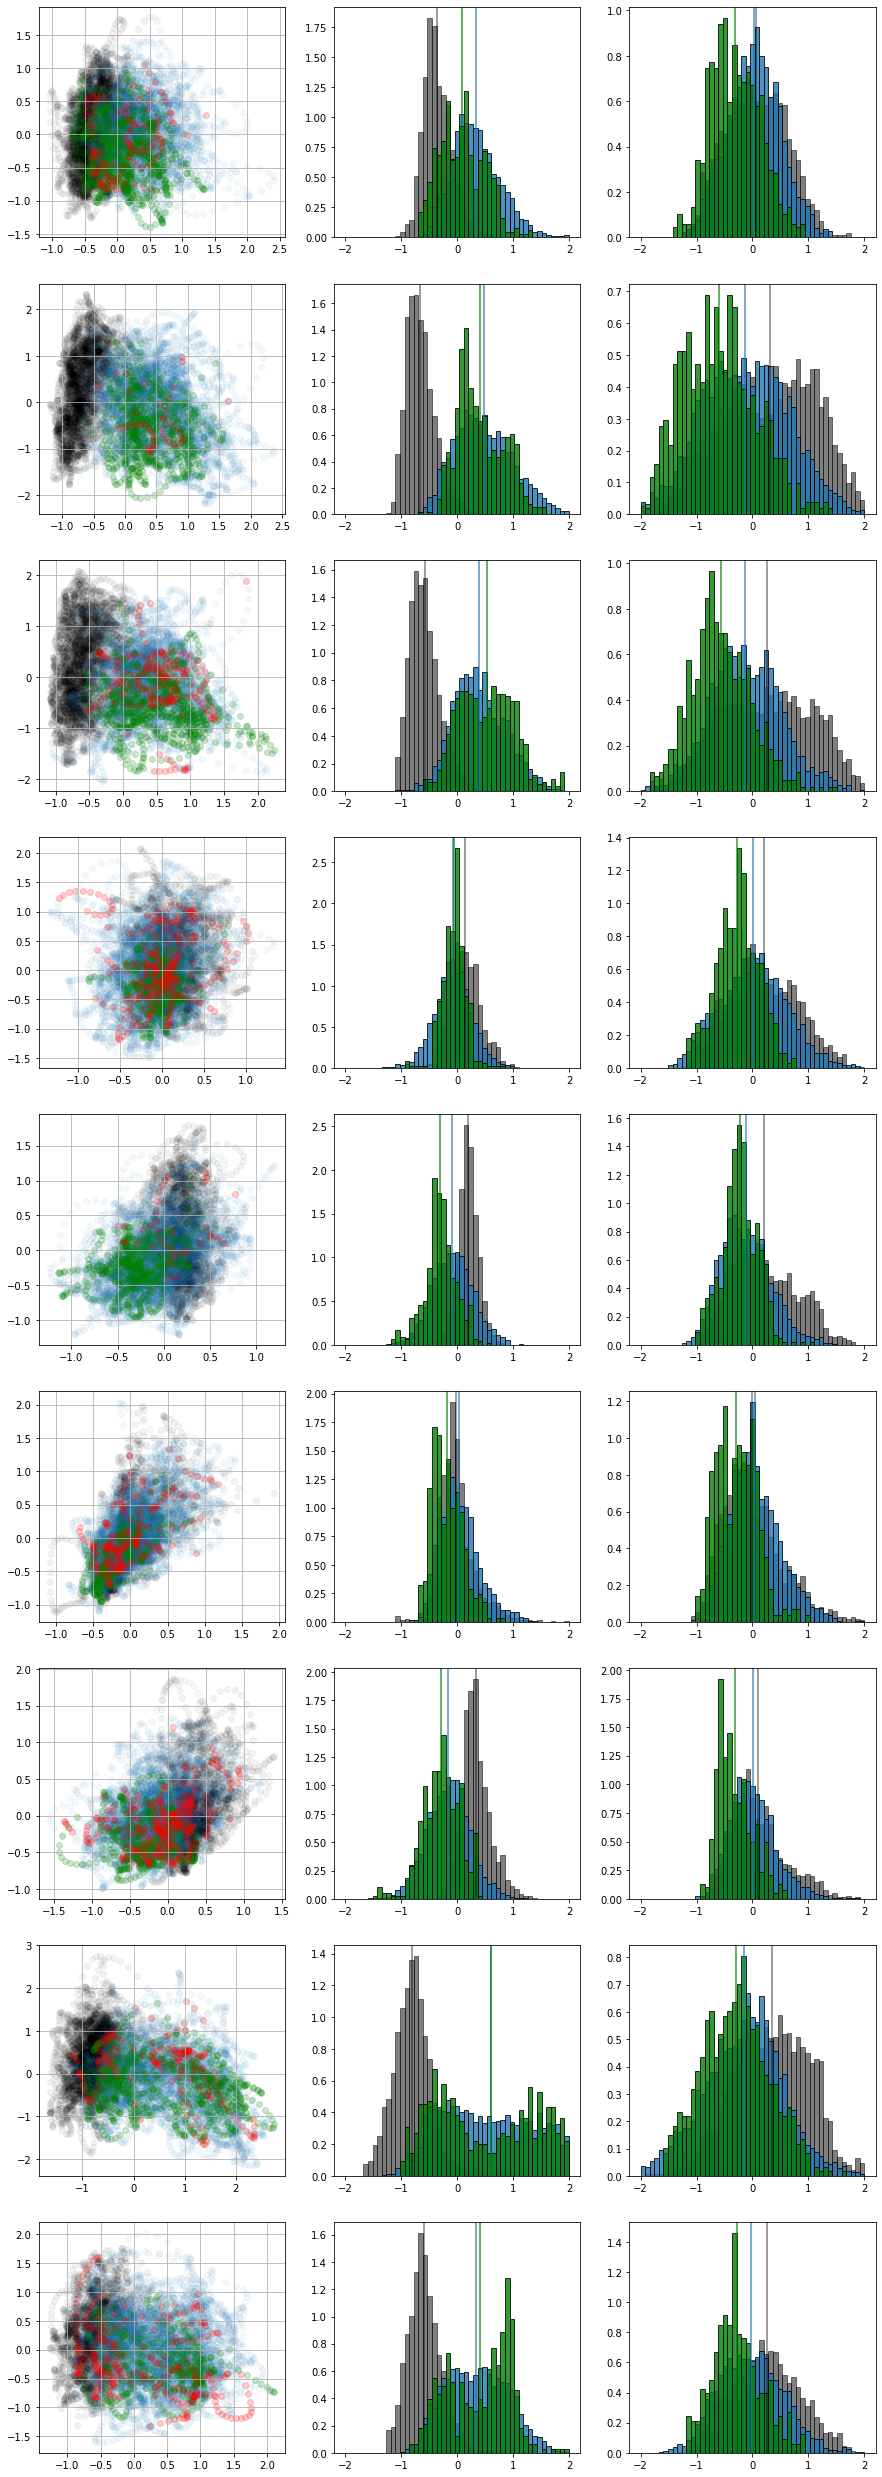

In [14]:
rows = len(selected)
cols = 3
size = 5
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_class_500.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    
    idxs_bgr = np.where(events[:, 1] == 1)[0]
    idxs_tgt = np.where(events[:, 1] == 2)[0]
    idxs_sil = np.where(events[:, 1] == 0)[0]
    
    idxs_srm_succ = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_srm_succ += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    
    idxs_srm_fail = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 0]:
        idxs_srm_fail += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))

    ax = axes[i][0]
    w1 = activity_at_phase(s_path, 1, do_pca=True)
    w4 = activity_at_phase(s_path, 4, do_pca=True)
    ax.scatter(w1[idxs_sil], w4[idxs_sil], alpha=0.05, color='black')
    ax.scatter(w1[idxs_bgr], w4[idxs_bgr], alpha=0.05, color='tab:blue')
    ax.scatter(w1[idxs_srm_succ], w4[idxs_srm_succ], alpha=0.2, color='green')
    ax.scatter(w1[idxs_srm_fail], w4[idxs_srm_fail], alpha=0.2, color='red')
    ax.grid()
    
    bins = np.linspace(-2, 2, 50)
    ax = axes[i][1]
    
    ax.hist(w1[idxs_sil], bins=bins, edgecolor='black', color='black', alpha=0.5, density=True)
    ax.hist(w1[idxs_bgr], bins=bins, edgecolor='black', color='tab:blue', alpha=0.8, density=True)
    ax.hist(w1[idxs_srm_succ], bins=bins, edgecolor='black', color='green', alpha=0.8, density=True)
    ax.axvline(w1[idxs_sil].mean(), color='black', alpha=0.5)
    ax.axvline(w1[idxs_bgr].mean(), color='tab:blue', alpha=0.8)
    ax.axvline(w1[idxs_srm_succ].mean(), color='green', alpha=0.8)
    #ax.hist(w1[idxs_srm_fail], bins=bins, edgecolor='black', color='red', alpha=0.8, density=True)
    
    ax = axes[i][2]
    ax.hist(w4[idxs_sil], bins=bins, edgecolor='black', color='black', alpha=0.5, density=True)
    ax.hist(w4[idxs_bgr], bins=bins, edgecolor='black', color='tab:blue', alpha=0.8, density=True)
    ax.hist(w4[idxs_srm_succ], bins=bins, edgecolor='black', color='green', alpha=0.8, density=True)
    ax.axvline(w4[idxs_sil].mean(), color='black', alpha=0.5)
    ax.axvline(w4[idxs_bgr].mean(), color='tab:blue', alpha=0.8)
    ax.axvline(w4[idxs_srm_succ].mean(), color='green', alpha=0.8)